#BERT UNCEASED

In [ ]:
!pip install tensorflow_text
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 5.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |████████████████████████████████| 438 kB 64.8 MB/s 
     |████████████████████████████████| 5.8 MB 44.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [ ]:
import tensorflow as tf
import pandas as pd

import tensorflow_hub as hub
import tensorflow_text as text
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.9.1


In [ ]:
dataset = pd.read_csv("/content/dataset4-fix (ENG ver).csv").values
dataset

array([['nonitrend is a multivitamin made from noni fruit extract natural raw materials the price is mummer pin neutral',
        'neutral'],
       ["b would instead of you think about things that are not certain it's better if you attend the new generation seminar your mind will be wider open neutral",
        'neutral'],
       ["b would instead of you think about things that are not certain it's better if you attend the new generation seminar your mind will be wider open neutral",
        'neutral'],
       ...,
       ["don't be afraid to be reported wkwkwk afraid", 'afraid'],
       ['so true until now if you are close to people like ove hingking afraid to repeat afraid',
        'afraid'],
       ["while worrying over and over again when one of the criminals named agoes has snatched a gun I'm afraid",
        'afraid']], dtype=object)

In [ ]:
import numpy as np
from random import randint

for row in range(len(dataset)):
  if dataset[row,1] == "angry":
    dataset[row,1] = 0
  elif dataset[row,1] == "happy":
    dataset[row,1] = 1
  elif dataset[row,1] == "sad":
    dataset[row,1] = 2
  elif dataset[row,1] == "interest":
    dataset[row,1] = 3
  elif dataset[row,1] == "neutral":
    dataset[row,1] = 4
  elif dataset[row,1] == "believe":
    dataset[row,1] = 5
  elif dataset[row,1] == "disgust":
    dataset[row,1] = 6
  elif dataset[row,1] == "afraid":
    dataset[row,1] = 7
  elif dataset[row,1] == "suprise":
    dataset[row,1] = 8



In [ ]:
from sklearn.model_selection import train_test_split
from numpy import array
from tensorflow.keras.utils import to_categorical

#One hot encoding
label = array(dataset[:,1])
label = to_categorical(label, 9)
label = pd.DataFrame(label)
y = label.drop([0], axis=1)

#Sentences
X = dataset[:,0]

In [ ]:
y

,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2510,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2511,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2512,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2513,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train = pd.DataFrame(X_train)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(8, activation='softmax', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

In [ ]:
historyuncased = model.fit(X_train,np.asarray(y_train).astype('float32'), epochs=10, validation_split=0.1)

Epoch 1/10
64/64 [==============================] - 32s 368ms/step - loss: 1.7231 - accuracy: 0.8923 - precision: 0.4286 - recall: 0.0017 - val_loss: 1.6819 - val_accuracy: 0.8921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 23s 364ms/step - loss: 1.5754 - accuracy: 0.8926 - precision: 0.8000 - recall: 0.0023 - val_loss: 1.5149 - val_accuracy: 0.8921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 24s 383ms/step - loss: 1.4510 - accuracy: 0.8933 - precision: 0.8947 - recall: 0.0097 - val_loss: 1.3906 - val_accuracy: 0.8921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 26s 400ms/step - loss: 1.3490 - accuracy: 0.8952 - precision: 0.8594 - recall: 0.0314 - val_loss: 1.3248 - val_accuracy: 0.8948 - val_precision: 0.7500 - val_recall: 0.0308
Epoch 5/10
64/64 [==============================] - 25s 386ms/step - loss: 1

In [ ]:
model.evaluate(X_test, np.asarray(y_test).astype('float32'))

8/8 [==============================] - 4s 362ms/step - loss: 0.9798 - accuracy: 0.9157 - precision: 0.9796 - recall: 0.2212


[0.9798290133476257, 0.91567462682724, 0.9795918464660645, 0.2211981564760208]

In [ ]:
# !mkdir saved_model-indoBertAfbudiman
model.save("saved_model-BERT_UNCASED2/BERT-alan1")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/saved_model-BERT_UNCASED2// /content/drive/MyDrive/TA\ Skripsi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

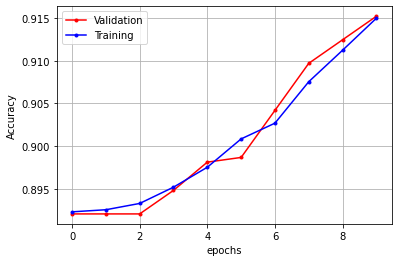

In [ ]:
acc = historyuncased.history['accuracy']
vacc = historyuncased.history['val_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, vacc, marker='.', c='red', label='Validation')
plt.plot(x_len, acc, marker='.', c='blue', label='Training')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

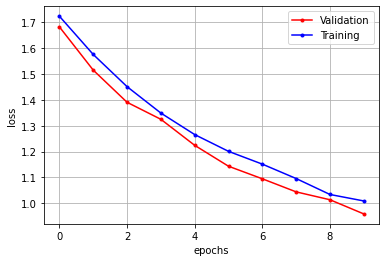

In [ ]:
loss = historyuncased.history['loss']
vloss = historyuncased.history['val_loss']

x_len = np.arange(len(loss))

plt.plot(x_len, vloss, marker='.', c='red', label='Validation')
plt.plot(x_len, loss, marker='.', c='blue', label='Training')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
prediction = model.predict(["I trust you"])
prdiction = np.argmax(prediction, axis=1)
print(prediction)

1/1 [==============================] - 1s 731ms/step
[[0.12497762 0.11509919 0.12656567 0.14146377 0.41584384 0.02100739
  0.025815   0.02922747]]


#BERT_indo

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#######################################
### -------- Load libraries ------- ###

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split



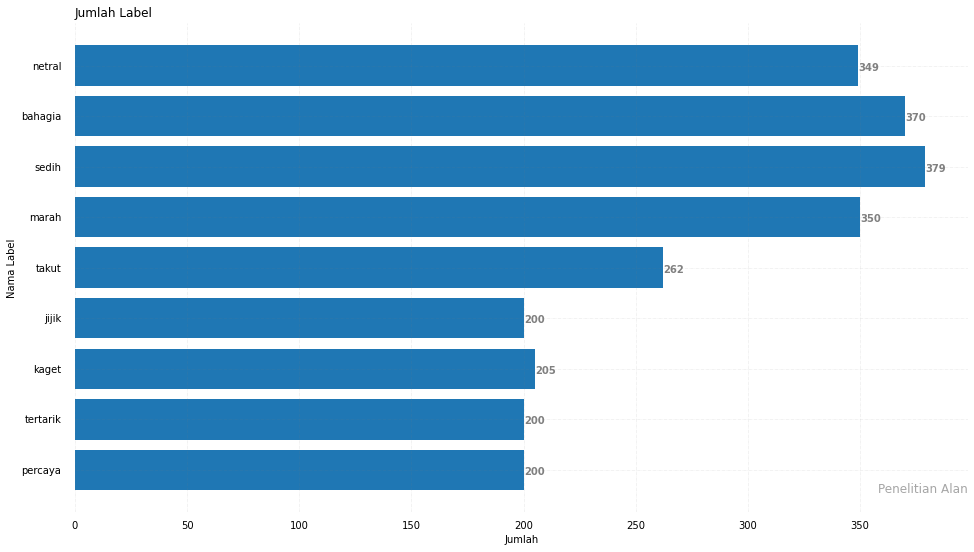

In [ ]:
from pandas._libs.hashtable import value_count
import pandas as pd

dataset = pd.read_csv("/content/dataset4-fix 2.csv")
# dataset
unique_value = dataset['label'].unique() # Dapetin unique value
value_counter = [] #Assign variable
for label in unique_value:
 value_counter.append(dataset['label'].value_counts()[label]) #Menghitung setiap label dan mamusakknya ke array


#Membuat graph
import matplotlib.pyplot as plt

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(unique_value, value_counter)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Jumlah Label',
             loc ='left', )
 
 # naming the x-axis
plt.xlabel('Jumlah')
# naming the y-axis
plt.ylabel('Nama Label')

# Add Text watermark
fig.text(0.9, 0.15, 'Penelitian Alan', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

In [ ]:
### --------- Import data --------- ###

# Import data from csv
data = pd.read_csv('/content/dataset4-fix 2.csv')
data.columns =  ['text', 'label']

# Select required columns
data = data[['text', 'label']]

# Remove a row if any of the three remaining columns are missing
data = data.dropna()

# Remove rows, where the label is present only ones (can't be split)
# data = data.groupby('Issue').filter(lambda x : len(x) > 1)
# data = data.groupby('Product').filter(lambda x : len(x) > 1)

# Set your model output as categorical and save in new label col
data['emosi_label'] = pd.Categorical(data['label'])

# Transform your output to numeric
data['label'] = data['emosi_label'].cat.codes

# Split into train and test - stratify over Issue
data, data_test = train_test_split(data, test_size = 0.1, stratify = data[['label']])

In [ ]:
### --------- Setup BERT ---------- ###

# Name of the BERT model to use
model_name = 'afbudiman/indobert-classification'

# Max length of tokens
max_length = 200

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'classifier.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
# attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
# inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
hidden_layer1 = Dense(units=64, name='hidden_layer1', activation='relu')(pooled_output)
hidden_layer2 = Dense(units=32, name='hidden_layer2', activation='relu')(hidden_layer1)

emosi = Dense(units=len(data.emosi_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emosi')(hidden_layer2)

outputs = {'emosi': emosi}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 200)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  124441344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [ ]:
## ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'emosi': CategoricalCrossentropy(from_logits = True)}
metric = {'emosi': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
data.emosi_label = data.emosi_label.map(label2num)
y_emosi = to_categorical(data['emosi_label'])

In [ ]:
# Tokenize the input (takes some time)
x = tokenizer(
    text=data['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Fit the model
historyindo = model.fit(
    # x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    x={'input_ids': x['input_ids']},
    y={'emosi': y_emosi},
    validation_split=0.1,
    batch_size=32,
    epochs=10)

Epoch 1/10
64/64 [==============================] - 93s 1s/step - loss: 1.0829 - accuracy: 0.9047 - val_loss: 1.3343 - val_accuracy: 0.6960
Epoch 2/10
64/64 [==============================] - 93s 1s/step - loss: 1.0140 - accuracy: 0.9249 - val_loss: 1.2754 - val_accuracy: 0.7225
Epoch 3/10
64/64 [==============================] - 93s 1s/step - loss: 0.9568 - accuracy: 0.9317 - val_loss: 1.2319 - val_accuracy: 0.7357
Epoch 4/10
64/64 [==============================] - 93s 1s/step - loss: 0.8954 - accuracy: 0.9494 - val_loss: 1.2192 - val_accuracy: 0.7313
Epoch 5/10
64/64 [==============================] - 93s 1s/step - loss: 0.8421 - accuracy: 0.9617 - val_loss: 1.1982 - val_accuracy: 0.7401
Epoch 6/10
64/64 [==============================] - 93s 1s/step - loss: 0.8078 - accuracy: 0.9617 - val_loss: 1.2686 - val_accuracy: 0.6696
Epoch 7/10
64/64 [==============================] - 93s 1s/step - loss: 0.7657 - accuracy: 0.9671 - val_loss: 1.1604 - val_accuracy: 0.7357
Epoch 8/10
64/64 [==

In [ ]:
# !mkdir saved_model-indoBertAfbudiman
model.save("saved_model-indoBertAfbudiman/BERT-alan")

INFO:tensorflow:Assets written to: saved_model-indoBertAfbudiman/BERT-alan/assets


INFO:tensorflow:Assets written to: saved_model-indoBertAfbudiman/BERT-alan/assets


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

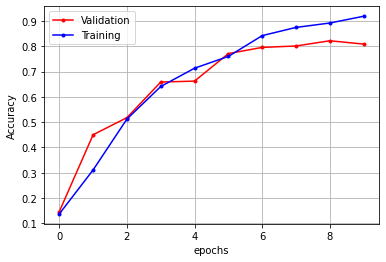

In [ ]:
vacc = historyindo.history['val_accuracy']
acc = historyindo.history['accuracy']

x_len = np.arange(len(vacc))

plt.plot(x_len, vacc, marker='.', c='red', label='Validation')
plt.plot(x_len, acc, marker='.', c='blue', label='Training')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

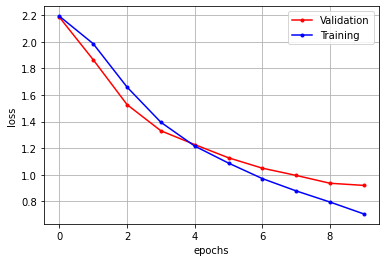

In [ ]:
vloss = historyindo.history['val_loss']
loss = historyindo.history['loss']

x_len = np.arange(len(loss))

plt.plot(x_len, vloss, marker='.', c='red', label='Validation')
plt.plot(x_len, loss, marker='.', c='blue', label='Training')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/saved_model-indoBertAfbudiman /content/drive/MyDrive/TA\ Skripsi

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
data_test.emosi_label = data_test.emosi_label.map(label2num)
test_y_emosi = to_categorical(data_test['emosi_label'])
test_x = tokenizer(
    text=data_test['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'emosi': test_y_emosi}
)

10/10 [==============================] - 4s 381ms/step - loss: 0.9037 - accuracy: 0.8007


## Predict single text

In [ ]:
## --------- Setup BERT ---------- ###

# Name of the BERT model to use
model_name = 'afbudiman/indobert-classification'

# Max length of tokens
max_length = 200

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/TA Skripsi/saved_model-indoBertAfbudiman/BERT-alan')

In [ ]:
import numpy as np

def predict_string(text):
    predict_x = tokenizer(
    text=[text],
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

    prediction = model.predict(x={'input_ids': predict_x['input_ids']})
    label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
    num2label = {v: k for k, v in label2num.items()}
    answer_real = []
    for i in prediction['emosi']:
      answer_real.append(np.argmax(i))
    string_answer = pd.DataFrame(answer_real).replace(num2label)
    return string_answer.values[0][0]

predict_string("hahh kok bisaa?")

'kaget'

## Infecerence multiple text

In [ ]:
### ----- Inference ------ ###
import random
from prettytable import PrettyTable

def revLabel(list):
  label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
  num2label = {v: k for k, v in label2num.items()}
  reversed = []
  for i in answer['emosi']:
    reversed.append(np.argmax(i))
  return pd.DataFrame(reversed).replace(num2label)

table = PrettyTable(['Sentence', 'Predicted', 'Actual'])
num_text=1
answer = model.predict( x={'input_ids': test_x['input_ids']})
for index in range(9):
  # seed = random.randint(0, len(test_x))
  table.add_row([data_test['text'].tolist()[index], revLabel(answer).values[index][0], revLabel(test_y_emosi).values[index][0]])
print(table)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+
|                                                                                                  Sentence                                                                                                  | Predicted |  Actual  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+
|                                                                          jam segini ngantuk pengen tidur tp takut bablas kwkwkwk                                                                           |   takut   |  takut   |
|                                           meliaagustin tyas jokowi imun terbai

##Wordcloud IndoBERT

In [ ]:
wr_data = pd.read_csv('/content/dataset4-fix (3).csv')
wr_data = wr_data.drop(columns=['label'], axis=1)

In [ ]:
for index in range(1,len(wr_data)):
  print(wr_data.values[index][0])

<function matplotlib.pyplot.show>

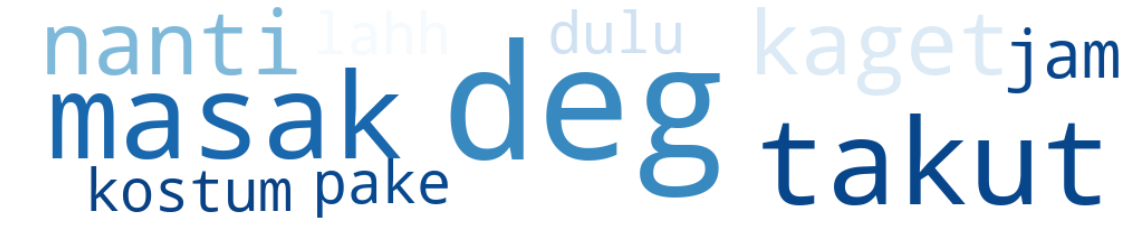

In [ ]:
#menampilkan wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Positif
train_kdr = wr_data
all_text_pst = ' '.join(wr_data.values[index][0] for word in train_kdr)
wordcloud = WordCloud(colormap = 'Blues', width = 1000, mode = 'RGBA', background_color = 'white').generate(all_text_pst)
plt.figure(figsize = (20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show




#Confussion Matrix

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
### ----- Inference ------ ###
def revLabel(answer):
  label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
  num2label = {v: k for k, v in label2num.items()}
  reversed = []
  for i in answer:
    reversed.append(np.argmax(i))
  return pd.DataFrame(reversed).replace(num2label)

# Ready test data
label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
num2label = {v: k for k, v in label2num.items()}
data_test.emosi_label = data_test.emosi_label.map(label2num)
test_x = tokenizer(
    text=data_test['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

answer = model.predict( x={'input_ids': test_x['input_ids']})
y_pred = revLabel(answer['emosi'])
y_true = revLabel(test_y_emosi)

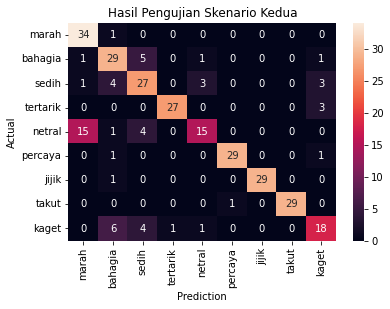

In [ ]:
ticklabels  = ['marah', 'bahagia', 'sedih', 'tertarik', 'netral', 'percaya', 'jijik', 'takut', 'kaget']

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred, labels=ticklabels)
sns.heatmap(cf_matrix, annot=True, xticklabels=ticklabels, yticklabels=ticklabels)
plt.title("Hasil Pengujian Skenario Kedua")
plt.ylabel("Actual")
plt.xlabel("Prediction")

plt.show()

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#Komparasi model

In [ ]:
acc = historyuncased.history['accuracy']
vacc = historyuncased.history['val_accuracy']
accindo = historyindo.history['accuracy']
vaccindo = historyindo.history['val_accuracy']
x_len = np.arange(len(acc))

plt.plot(x_len, vacc, marker='.', c='red', label='Validation_uncased')
plt.plot(x_len, acc, marker='.', c='blue', label='Training_uncased')
plt.plot(x_len, vaccindo, marker='.', c='green', label='Validation_indo')
plt.plot(x_len, accindo, marker='.', c='orange', label='Training_indo')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

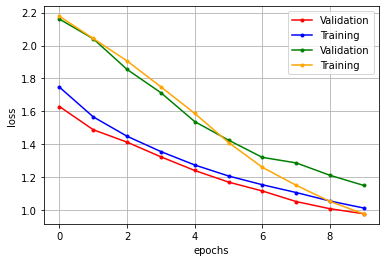

In [ ]:
loss = historyuncased.history['loss']
vloss = historyuncased.history['val_loss']
lossindo = historyindo.history ['loss']
vlossindo = historyindo.history ['val_loss']

x_len = np.arange(len(loss))

plt.plot(x_len, vloss, marker='.', c='red', label='Validation')
plt.plot(x_len, loss, marker='.', c='blue', label='Training')
plt.plot(x_len, vlossindo, marker='.', c='green', label='Validation')
plt.plot(x_len, lossindo, marker='.', c='orange', label='Training')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

#UNCASED CONFUSSION MATRIX


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/TA Skripsi/saved_model-BERT_UNCASED2/BERT-alan1')

In [ ]:
prediction[0]

array([0.10104591, 0.08859257, 0.11494333, 0.13106425, 0.50033975,
       0.02763938, 0.01926039, 0.01711442], dtype=float32)

In [ ]:
prediction = model.predict([["I trust you"]])
prediction = np.argmax(prediction[0])
print(prediction)

1/1 [==============================] - 0s 58ms/step
4


In [ ]:
arr = [0, 1, 2]
pd.DataFrame(arr).replace(num2label)

,0
0,marah
1,bahagia
2,sedih


In [ ]:
### ----- Inference ------ ###
def revLabel(answer):
  label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
  num2label = {v: k for k, v in label2num.items()}
  reversed = []
  for i in answer:
    reversed.append(np.argmax(i))
  return pd.DataFrame(reversed)[0].replace(num2label)

# Ready test data
label2num = {'marah':0, 'bahagia':1, 'sedih':2, 'tertarik':3, 'netral':4, 'percaya':5, 'jijik':6, 'takut':7, 'kaget':8}
num2label = {v: k for k, v in label2num.items()}
data_test.emosi_label = data_test.emosi_label.map(label2num)


answer = model.predict(X_test)
y_pred = revLabel(answer)
y_true = revLabel(y_test.values)

8/8 [==============================] - 3s 389ms/step


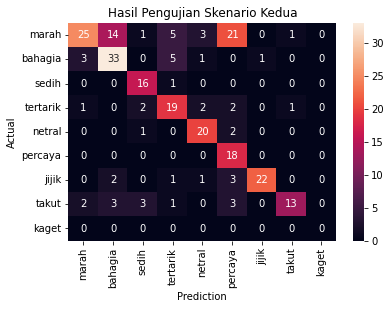

In [ ]:
ticklabels  = ['marah', 'bahagia', 'sedih', 'tertarik', 'netral', 'percaya', 'jijik', 'takut', 'kaget']

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred, labels=ticklabels)
sns.heatmap(cf_matrix, annot=True, xticklabels=ticklabels, yticklabels=ticklabels)
plt.title("Hasil Pengujian Skenario Kedua")
plt.ylabel("Actual")
plt.xlabel("Prediction")

plt.show()

In [ ]:
# import Indonesian lexicon
spell.lex <- read.csv("data_input/colloquial-indonesian-lexicon.csv")

# replace internet slang
tweets <- replace_internet_slang(tweets, slang = paste0("\\b",
                                                        spell.lex$slang, "\\b"),
                                 replacement = spell.lex$formal, ignore.case = TRUE)